
# **Running Hive on Pyspark in Colab**

Prepare PySpark Cluster

In [2]:
# innstall java
!apt-get install openjdk-8-jdk-headless -qq > /dev/null

# install spark (change the version number if needed)
!wget -q https://archive.apache.org/dist/spark/spark-3.0.0/spark-3.0.0-bin-hadoop3.2.tgz

# unzip the spark file to the current folder
!tar xf spark-3.0.0-bin-hadoop3.2.tgz

# set your spark folder to your system path environment.
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.0.0-bin-hadoop3.2"


# install findspark using pip
!pip install -q findspark

#Run a local spark session to test your installation:

In [4]:
import findspark
findspark.init()
from pyspark.sql import SparkSession
#spark = SparkSession.builder.master("local[*]").getOrCreate()
spark = SparkSession.builder.master("local[*]").enableHiveSupport().getOrCreate()


In [5]:
from pyspark.ml.feature import VectorAssembler

from pyspark.ml.regression import LinearRegression

from pyspark.ml.feature import VectorAssembler, StandardScaler, PCA

import numpy as np

import pandas as pd

import matplotlib.pyplot as plt

# Upload Data to Working Directory

In [6]:
from google.colab import files
files.upload()

Saving BostonHousing.csv to BostonHousing.csv


{'BostonHousing.csv': b'crim,zn,indus,chas,nox,rm,age,dis,rad,tax,ptratio,b,lstat,medv\r\n0.00632,18,2.31,0,0.538,6.575,65.2,4.09,1,296,15.3,396.9,4.98,24\r\n0.02731,0,7.07,0,0.469,6.421,78.9,4.9671,2,242,17.8,396.9,9.14,21.6\r\n0.02729,0,7.07,0,0.469,7.185,61.1,4.9671,2,242,17.8,392.83,4.03,34.7\r\n0.03237,0,2.18,0,0.458,6.998,45.8,6.0622,3,222,18.7,394.63,2.94,33.4\r\n0.06905,0,2.18,0,0.458,7.147,54.2,6.0622,3,222,18.7,396.9,5.33,36.2\r\n0.02985,0,2.18,0,0.458,6.43,58.7,6.0622,3,222,18.7,394.12,5.21,28.7\r\n0.08829,12.5,7.87,0,0.524,6.012,66.6,5.5605,5,311,15.2,395.6,12.43,22.9\r\n0.14455,12.5,7.87,0,0.524,6.172,96.1,5.9505,5,311,15.2,396.9,19.15,27.1\r\n0.21124,12.5,7.87,0,0.524,5.631,100,6.0821,5,311,15.2,386.63,29.93,16.5\r\n0.17004,12.5,7.87,0,0.524,6.004,85.9,6.5921,5,311,15.2,386.71,17.1,18.9\r\n0.22489,12.5,7.87,0,0.524,6.377,94.3,6.3467,5,311,15.2,392.52,20.45,15\r\n0.11747,12.5,7.87,0,0.524,6.009,82.9,6.2267,5,311,15.2,396.9,13.27,18.9\r\n0.09378,12.5,7.87,0,0.524,5.889,39,5

# Load Data to Spark Cluster

In [7]:
dataset = spark.read.csv('BostonHousing.csv',inferSchema=True, header =True)

In [8]:
dataset.show(7)

+-------+----+-----+----+-----+-----+----+------+---+---+-------+------+-----+----+
|   crim|  zn|indus|chas|  nox|   rm| age|   dis|rad|tax|ptratio|     b|lstat|medv|
+-------+----+-----+----+-----+-----+----+------+---+---+-------+------+-----+----+
|0.00632|18.0| 2.31|   0|0.538|6.575|65.2|  4.09|  1|296|   15.3| 396.9| 4.98|24.0|
|0.02731| 0.0| 7.07|   0|0.469|6.421|78.9|4.9671|  2|242|   17.8| 396.9| 9.14|21.6|
|0.02729| 0.0| 7.07|   0|0.469|7.185|61.1|4.9671|  2|242|   17.8|392.83| 4.03|34.7|
|0.03237| 0.0| 2.18|   0|0.458|6.998|45.8|6.0622|  3|222|   18.7|394.63| 2.94|33.4|
|0.06905| 0.0| 2.18|   0|0.458|7.147|54.2|6.0622|  3|222|   18.7| 396.9| 5.33|36.2|
|0.02985| 0.0| 2.18|   0|0.458| 6.43|58.7|6.0622|  3|222|   18.7|394.12| 5.21|28.7|
|0.08829|12.5| 7.87|   0|0.524|6.012|66.6|5.5605|  5|311|   15.2| 395.6|12.43|22.9|
+-------+----+-----+----+-----+-----+----+------+---+---+-------+------+-----+----+
only showing top 7 rows



###**Combine features to a single vector columns using VectorAssembler**

In [9]:
# List of columns that we want to combine into a single vector column
feature_columns = [col for col in dataset.columns if col != 'medv']

# Initialize the VectorAssembler
assembler = VectorAssembler(inputCols=feature_columns, outputCol="features")

# Use the VectorAssembler to transform the dataset
assembled_dataset = assembler.transform(dataset)

# Display the resulting DataFrame with the 'features' column
assembled_dataset.select("features", "medv").show()

+--------------------+----+
|            features|medv|
+--------------------+----+
|[0.00632,18.0,2.3...|24.0|
|[0.02731,0.0,7.07...|21.6|
|[0.02729,0.0,7.07...|34.7|
|[0.03237,0.0,2.18...|33.4|
|[0.06905,0.0,2.18...|36.2|
|[0.02985,0.0,2.18...|28.7|
|[0.08829,12.5,7.8...|22.9|
|[0.14455,12.5,7.8...|27.1|
|[0.21124,12.5,7.8...|16.5|
|[0.17004,12.5,7.8...|18.9|
|[0.22489,12.5,7.8...|15.0|
|[0.11747,12.5,7.8...|18.9|
|[0.09378,12.5,7.8...|21.7|
|[0.62976,0.0,8.14...|20.4|
|[0.63796,0.0,8.14...|18.2|
|[0.62739,0.0,8.14...|19.9|
|[1.05393,0.0,8.14...|23.1|
|[0.7842,0.0,8.14,...|17.5|
|[0.80271,0.0,8.14...|20.2|
|[0.7258,0.0,8.14,...|18.2|
+--------------------+----+
only showing top 20 rows



## **Standardising the dataset**

In [10]:
from pyspark.ml.feature import StandardScaler
from pyspark.ml import Pipeline

# Create a StandardScaler instance
scaler = StandardScaler(inputCol="features", outputCol="scaled_features", withStd=True, withMean=True)

# Fit the StandardScaler on the dataset
scaler_model = scaler.fit(assembled_dataset)

# Transform the dataset to obtain standardized features
scaled_dataset = scaler_model.transform(assembled_dataset)

# Display the standardized features
scaled_dataset.select("features", "scaled_features").show(6)

# Now, you can perform PCA on the standardized features


+--------------------+--------------------+
|            features|     scaled_features|
+--------------------+--------------------+
|[0.00632,18.0,2.3...|[-0.4193669292132...|
|[0.02731,0.0,7.07...|[-0.4169266699640...|
|[0.02729,0.0,7.07...|[-0.4169289951277...|
|[0.03237,0.0,2.18...|[-0.4163384035610...|
|[0.06905,0.0,2.18...|[-0.4120740534296...|
|[0.02985,0.0,2.18...|[-0.4166313741807...|
+--------------------+--------------------+
only showing top 6 rows



## **PCA  Analysis**

In [11]:

components=2
# Create a PCA instance with the desired number of components
pca = PCA(k=components, inputCol="scaled_features", outputCol="pca_features")

# Fit the PCA model on the scaled dataset
pca_model = pca.fit(scaled_dataset)

# Transform the dataset to obtain the two principal components
pca_result = pca_model.transform(scaled_dataset)
print("Explainde variance ratio",pca_model.explainedVariance.toArray())
# Display the resulting DataFrame with the two principal components and 'medv' column
pca_result.select("features","scaled_features","pca_features").show(6)


Explainde variance ratio [0.47129606 0.11025193]
+--------------------+--------------------+--------------------+
|            features|     scaled_features|        pca_features|
+--------------------+--------------------+--------------------+
|[0.00632,18.0,2.3...|[-0.4193669292132...|[2.09622303023858...|
|[0.02731,0.0,7.07...|[-0.4169266699640...|[1.45581098944742...|
|[0.02729,0.0,7.07...|[-0.4169289951277...|[2.07254655194818...|
|[0.03237,0.0,2.18...|[-0.4163384035610...|[2.60892175886434...|
|[0.06905,0.0,2.18...|[-0.4120740534296...|[2.45575477193107...|
|[0.02985,0.0,2.18...|[-0.4166313741807...|[2.21266184319277...|
+--------------------+--------------------+--------------------+
only showing top 6 rows



## **collecte in numpy array and convert to pandas dataframe**

In [12]:
import numpy as np

# Collect the "pca_features" column as a list
pca_features_list = pca_result.select("pca_features").rdd.map(lambda row: row[0].toArray()).collect()

# Convert the list to a NumPy array
pca_features_array = np.array(pca_features_list)
pca_features_array


array([[2.09622303, 0.77234843],
       [1.45581099, 0.59139995],
       [2.07254655, 0.59904658],
       ...,
       [0.31205166, 1.15410433],
       [0.27025162, 1.04033206],
       [0.12567884, 0.76122473]])

In [13]:
import pandas as pd

# Create a Pandas DataFrame from the NumPy array
pandas_df = pd.DataFrame(data=pca_features_array, columns=["PC1", "PC2"])

pandas_df

,PC1,PC2
0,2.096223,0.772348
1,1.455811,0.591400
2,2.072547,0.599047
3,2.608922,-0.006864
4,2.455755,0.097615
...,...,...
501,0.314656,0.723568
502,0.110404,0.758557
503,0.312052,1.154104
504,0.270252,1.040332


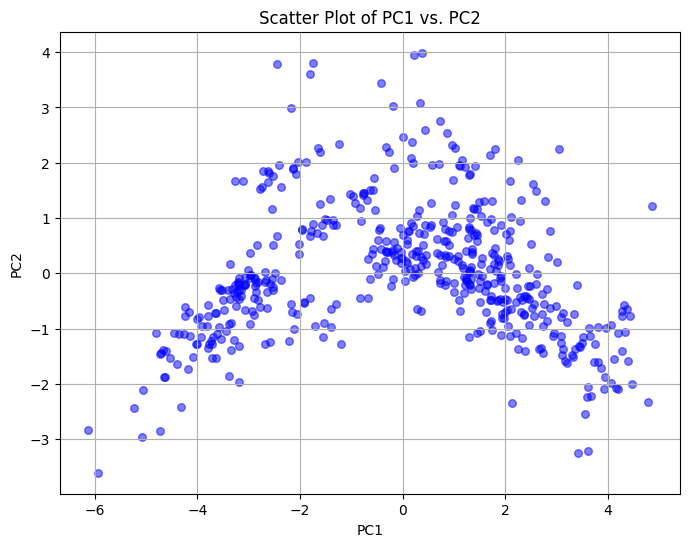

In [14]:
import matplotlib.pyplot as plt

#  'pandas_df' contains the two principal components as 'PC1' and 'PC2'
pc1 = pandas_df['PC1']
pc2 = pandas_df['PC2']

# Create a scatter plot
plt.figure(figsize=(8, 6))
plt.scatter(pc1, pc2, c='blue', marker='o', s=30, alpha=0.5)
plt.title('Scatter Plot of PC1 vs. PC2')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.grid()
plt.show()


## **Using the same vector assembler we did in the fist**

In [15]:
# List of columns that we want to combine into a single vector column, as we alreeady have the vector assembler , we will use the same dataset to build and train the model.
# Use the VectorAssembler to transform the dataset
df = assembler.transform(dataset)

# Display the resulting DataFrame with the 'features' column
final=df.select("features", "medv")
final.show(10)

+--------------------+----+
|            features|medv|
+--------------------+----+
|[0.00632,18.0,2.3...|24.0|
|[0.02731,0.0,7.07...|21.6|
|[0.02729,0.0,7.07...|34.7|
|[0.03237,0.0,2.18...|33.4|
|[0.06905,0.0,2.18...|36.2|
|[0.02985,0.0,2.18...|28.7|
|[0.08829,12.5,7.8...|22.9|
|[0.14455,12.5,7.8...|27.1|
|[0.21124,12.5,7.8...|16.5|
|[0.17004,12.5,7.8...|18.9|
+--------------------+----+
only showing top 10 rows



## **Split dataset into training and testing dataset**

In [16]:


# Split the dataset into training and testing sets
train_ratio = 0.8  # 80% of the data for training
test_ratio = 1.0 - train_ratio  # Remaining 20% for testing
seed = 123  # Random seed for reproducibility

# Assuming 'final' contains the assembled dataset with 'features' and 'medv' columns
train_data, test_data = final.randomSplit([train_ratio, test_ratio], seed=seed)

train_data.show(5)
test_data.show(5)

+--------------------+----+
|            features|medv|
+--------------------+----+
|[0.00632,18.0,2.3...|24.0|
|[0.00906,90.0,2.9...|32.2|
|[0.01301,35.0,1.5...|32.7|
|[0.01311,90.0,1.2...|35.4|
|[0.0136,75.0,4.0,...|18.9|
+--------------------+----+
only showing top 5 rows

+--------------------+----+
|            features|medv|
+--------------------+----+
|[0.01096,55.0,2.2...|22.0|
|[0.01381,80.0,0.4...|50.0|
|[0.01709,90.0,2.0...|30.1|
|[0.01778,95.0,1.4...|32.9|
|[0.02055,85.0,0.7...|24.7|
+--------------------+----+
only showing top 5 rows



## **Linear Regression model**

In [17]:
from pyspark.ml.regression import LinearRegression
from pyspark.ml.evaluation import RegressionEvaluator

# Create a Linear Regression model
lr = LinearRegression(featuresCol="features", labelCol="medv")

# Fit the model to the training data
lr_model = lr.fit(train_data)

# Make predictions on the test data
predictions = lr_model.transform(test_data)

## **Model coefficients and intercept**

In [18]:
# Access the model coefficients and intercept
coefficients = lr_model.coefficients
intercept = lr_model.intercept

# Display the model coefficients and intercept
print("Coefficients:", coefficients)
print("Intercept:", intercept)


Coefficients: [-0.11863475807453558,0.04280903435252943,0.028095096718616645,3.2602319362710137,-18.245531686435953,3.396816578103953,0.0019494239349556908,-1.5098540709801362,0.307692513901614,-0.01092737052509682,-1.0045464021300223,0.010207988598329875,-0.5532708946953689]
Intercept: 39.885571875835936


**Coefficients:**

The coefficients represent the weights assigned to each feature in the linear regression model. These weights determine the strength and direction of the relationship between each feature and the target variable ("medv" in this case).
Each coefficient corresponds to a specific feature in the same order as the features appeared in the dataset.
For example, interpreting some of the coefficients:

The coefficient for the first feature is approximately -0.119. This means that for every one-unit increase in this feature, the predicted value of "medv" is expected to decrease by approximately 0.119 units, assuming all other variables are held constant.
The coefficient for the second feature is approximately 0.043. This means that for every one-unit increase in this feature, the predicted value of "medv" is expected to increase by approximately 0.043 units.

**Intercept:**

The intercept (also known as the bias or constant term) represents the predicted value of the target variable when all the features are set to zero.
In your case, the intercept is approximately 39.886. This means that when all the features have a value of zero, the predicted value of "medv" is approximately 39.886. The intercept serves to shift the prediction up or down.

## **Evaluate model for test dataset**

In [19]:
from pyspark.ml.evaluation import RegressionEvaluator

# Make predictions on the test data
predictions = lr_model.transform(test_data)

# Create a RegressionEvaluator to calculate metrics
evaluator = RegressionEvaluator(labelCol="medv", predictionCol="prediction")



### **Evaluation metrics**

In [20]:
# Calculate and print various evaluation metrics
rmse = evaluator.evaluate(predictions, {evaluator.metricName: "rmse"})
mse = evaluator.evaluate(predictions, {evaluator.metricName: "mse"})
mae = evaluator.evaluate(predictions, {evaluator.metricName: "mae"})
r2 = evaluator.evaluate(predictions, {evaluator.metricName: "r2"})

print("Root Mean Squared Error (RMSE):", rmse)
print("Mean Squared Error (RMSE):", mse)
print("Mean Absolute Error (MAE):", mae)
print("R-squared (R2):", r2)


Root Mean Squared Error (RMSE): 3.952468980908394
Mean Squared Error (RMSE): 15.622011045043038
Mean Absolute Error (MAE): 2.9764433568995194
R-squared (R2): 0.8024391787661578


### **HyperParameter Tuning and Cross validation**

In [21]:
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from pyspark.ml.evaluation import RegressionEvaluator

# Define a Linear Regression model
lr = LinearRegression(featuresCol="features", labelCol="medv")

# Create a RegressionEvaluator
evaluator = RegressionEvaluator(labelCol="medv", predictionCol="prediction", metricName="rmse")

# Define a grid of hyperparameters for cross-validation
param_grid = ParamGridBuilder() \
    .addGrid(lr.regParam, [0.01, 0.1, 1.0]) \
    .addGrid(lr.elasticNetParam, [0.0, 0.5, 1.0]) \
    .build()

# Create a cross-validator with k-fold cross-validation (e.g., 5 folds)
crossval = CrossValidator(estimator=lr, estimatorParamMaps=param_grid, evaluator=evaluator, numFolds=5)

# Fit the cross-validator on the training data
cv_model = crossval.fit(train_data)

# Get the best model from cross-validation
best_lr_model = cv_model.bestModel

# Evaluate the best model on the test dataset
best_model_test_results = best_lr_model.evaluate(test_data)
print("Best Model - Root Mean Squared Error (RMSE):", best_model_test_results.rootMeanSquaredError)
print("Best Model - Mean Absolute Error (MAE):", best_model_test_results.meanAbsoluteError)
print("Best Model - R2 Score:", best_model_test_results.r2)

# Obtain the best hyperparameters
best_reg_param = best_lr_model.getOrDefault("regParam")
best_elastic_net_param = best_lr_model.getOrDefault("elasticNetParam")

print("Best Regularization Parameter (regParam):", best_reg_param)
print("Best Elastic Net Parameter (elasticNetParam):", best_elastic_net_param)


Best Model - Root Mean Squared Error (RMSE): 3.9498214953884974
Best Model - Mean Absolute Error (MAE): 2.9601779009560505
Best Model - R2 Score: 0.8027037547778014
Best Regularization Parameter (regParam): 0.1
Best Elastic Net Parameter (elasticNetParam): 0.0



The cross-validated RMSE is approximately 3.94. This means, on average model's predictions have an error of about 3.982 units in the target variable, "medv."

the cross-validated MAE is approximately 2.96. This indicates that model's predictions have an absolute error of about 2.96 units in the target variable.

R-squared, also known as the coefficient of determination, measures the proportion of the variance in the target variable that is explained by the model. It ranges from 0 to 1, where higher values are better.
In this case the cross-validated R-squared is approximately 0.802. This means that the model explains around 80.2% of the variance in the target variable. A higher R-squared indicates a better fit.
These metrics are used to assess the quality and performance of your linear regression model. In general, lower RMSE and MAE and higher R-squared values indicate a better model fit and predictive performance.





